In [1]:
# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip ml-100k.zip 
# !mkdir ./data/ml-100k/
# !mv ml-100k/* ./data/ml-100k/
# !rm -rf ml-100k/
# !rm ml-100k.zip

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv(
    "data/ml-100k/u.data",
    sep="\t",
    names=["user_id", "item_id", "rating", "timestamp"]
)
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

In [4]:
user = pd.read_csv(
    "data/ml-100k/u.user", 
    sep="|", 
    names=["user_id", "age", "gender", "occupation", "zip_code"]
)

In [5]:
genre = pd.read_csv(
    "data/ml-100k/u.genre", 
    sep="|", 
    names=["genre", "genre_id"]
).dropna()

In [6]:
occupation = pd.read_csv(
    "data/ml-100k/u.occupation", 
    sep="|", 
    names=["occupation"]
).reset_index().rename(columns={"index": "occupation_id"})

In [7]:
item_cols = [
    "item_id",
    "title",
    "release_date",
    "video_release_date",
    "imdb_url",
    "unknown",
    "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
    "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
    "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

items = pd.read_csv(
    "data/ml-100k/u.item",
    sep="|",
    names=item_cols,
    encoding="latin-1"
)

In [8]:
n_users = data.user_id.nunique() # user.shape[0]
n_items = data.item_id.nunique() # items.shape[0]

n_obs = data.shape[0]
n_total = n_users * n_items

density = n_obs / n_total
sparsity = 1 - density

print('Количество уникальных пользователей:', n_users)
print('Количество уникальных итемов:', n_items)
print(f'Плотность: {density:.3}')
print(f'Разреженность: {sparsity:.3}')

Количество уникальных пользователей: 943
Количество уникальных итемов: 1682
Плотность: 0.063
Разреженность: 0.937


In [36]:
users_agg_stats = data.groupby('user_id').agg(
    items_cnt=('item_id', 'nunique'),
    avg_rating=('rating', lambda x: round(x.mean(), 3)),
    min_rating=('rating', 'min'),
    percentile_90=('rating', lambda x: round(x.quantile(.9), 3)),
    percentile_95=('rating', lambda x: round(x.quantile(.95), 3)),
    first_date=('timestamp', lambda x: min(x)),
    last_date=('timestamp', lambda x: max(x))
).reset_index()
users_agg_stats['first_date'] = users_agg_stats['first_date'].dt.normalize()
users_agg_stats['last_date'] = users_agg_stats['last_date'].dt.normalize()
users_agg_stats['duration'] = (users_agg_stats['last_date'] - users_agg_stats['first_date']).dt.days

users_agg_stats = users_agg_stats.sort_values('items_cnt', ascending=False).reset_index(drop=True)
users_agg_stats['rank'] = range(len(users_agg_stats))

users_agg_stats['items_cumsum'] = users_agg_stats['items_cnt'].cumsum()
users_agg_stats['items_share'] = users_agg_stats['items_cumsum'] / users_agg_stats['items_cnt'].sum()


users_agg_stats.head(3)

,user_id,items_cnt,avg_rating,min_rating,percentile_90,percentile_95,first_date,last_date,duration,rank,items_cumsum,items_share
0,405,737,1.834,1,4.0,5.0,1998-01-23,1998-01-23,0,0,737,0.00737
1,655,685,2.908,1,4.0,4.0,1998-02-14,1998-04-19,64,1,1422,0.01422
2,13,636,3.097,1,5.0,5.0,1997-12-07,1998-04-18,132,2,2058,0.02058


In [37]:
N = len(users_agg_stats)
total = users_agg_stats['items_cnt'].sum()

for p in [0.01, 0.05, 0.10, 0.20]:
    k = max(1, int(N * p))
    share = users_agg_stats.iloc[:k]['items_cnt'].sum() / total
    print(f"Top {int(p*100)}% users ({k} users) -> {share:.2%} interactions")

Top 1% users (9 users) -> 5.06% interactions
Top 5% users (47 users) -> 18.91% interactions
Top 10% users (94 users) -> 31.94% interactions
Top 20% users (188 users) -> 51.36% interactions


In [ ]:
items_agg_stats = data.groupby('item_id').agg(
    avg_rating=('rating', lambda x: round(x.mean(), 3)),
    reviews_cnt=('rating', 'size'),
    min_rating=('rating', 'min'),
    percentile_90=('rating', lambda x: round(x.quantile(.9), 3)),
    percentile_95=('rating', lambda x: round(x.quantile(.95), 3)),
    first_date=('timestamp', lambda x: min(x)),
    last_date=('timestamp', lambda x: max(x))
).reset_index()
items_agg_stats['first_date'] = items_agg_stats['first_date'].dt.normalize()
items_agg_stats['last_date'] = items_agg_stats['last_date'].dt.normalize()
items_agg_stats['duration'] = (items_agg_stats['last_date'] - items_agg_stats['first_date']).dt.days

items_agg_stats = items_agg_stats.sort_values('reviews_cnt', ascending=False).reset_index(drop=True)
items_agg_stats['rank'] = range(len(items_agg_stats))

items_agg_stats['reviews_cumsum'] = items_agg_stats['reviews_cnt'].cumsum()
items_agg_stats['reviews_share'] = items_agg_stats['reviews_cumsum'] / items_agg_stats['reviews_cnt'].sum()

items_agg_stats.head(3)

,item_id,avg_rating,reviews_cnt,min_rating,percentile_90,percentile_95,first_date,last_date,duration,rank,reviews_cumsum,reviews_share
0,50,4.358,583,1,5.0,5.0,1997-09-20,1998-04-22,214,0,583,0.00583
1,258,3.804,509,1,5.0,5.0,1997-09-20,1998-04-22,214,1,1092,0.01092
2,100,4.156,508,1,5.0,5.0,1997-09-20,1998-04-22,214,2,1600,0.01600


In [32]:
N = len(items_agg_stats)
total = items_agg_stats['reviews_cnt'].sum()

for p in [0.01, 0.05, 0.10, 0.20]:
    k = max(1, int(N * p))
    share = items_agg_stats.iloc[:k]['reviews_cnt'].sum() / total
    print(f"Top {int(p*100)}% items ({k} items) -> {share:.2%} interactions")

Top 1% items (16 items) -> 7.26% interactions
Top 5% items (84 items) -> 26.38% interactions
Top 10% items (168 items) -> 42.70% interactions
Top 20% items (336 items) -> 64.62% interactions


In [29]:
items_ratings_stats = data.groupby(['item_id', 'rating']).agg(
    rating_cnt=('user_id', 'size')
).reset_index()
items_ratings_stats['share'] = \
    items_ratings_stats['rating_cnt'] / items_ratings_stats.groupby('item_id')['rating_cnt'].transform('sum')
items_ratings_stats.head(3)

,item_id,rating,rating_cnt,share
0,1,1,8,0.017699
1,1,2,27,0.059735
2,1,3,96,0.212389


### Items Long-tail Plots

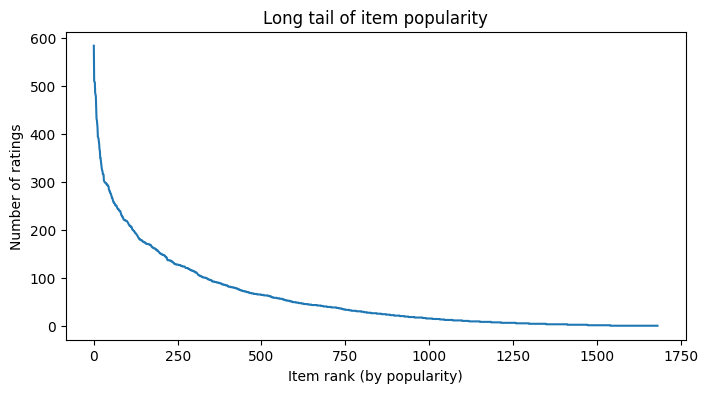

In [30]:
plt.figure(figsize=(8, 4))
plt.plot(items_agg_stats['rank'], items_agg_stats['reviews_cnt'])
plt.xlabel('Item rank (by popularity)')
plt.ylabel('Number of ratings')
plt.title('Long tail of item popularity')
plt.show()

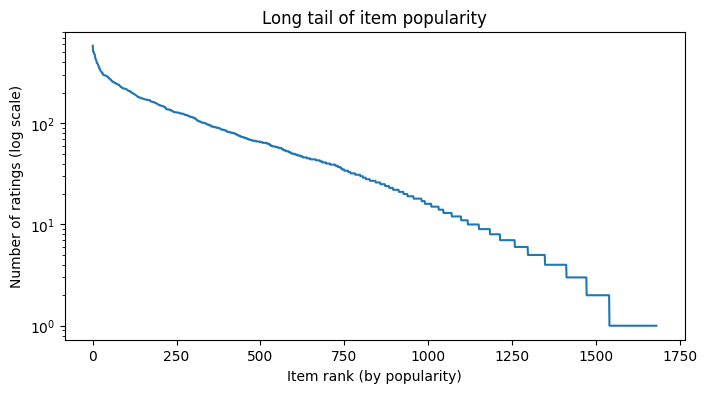

In [20]:
plt.figure(figsize=(8, 4))
plt.plot(items_agg_stats['rank'], items_agg_stats['reviews_cnt'])
plt.yscale('log')
plt.xlabel('Item rank (by popularity)')
plt.ylabel('Number of ratings (log scale)')
plt.title('Long tail of item popularity')
plt.show()

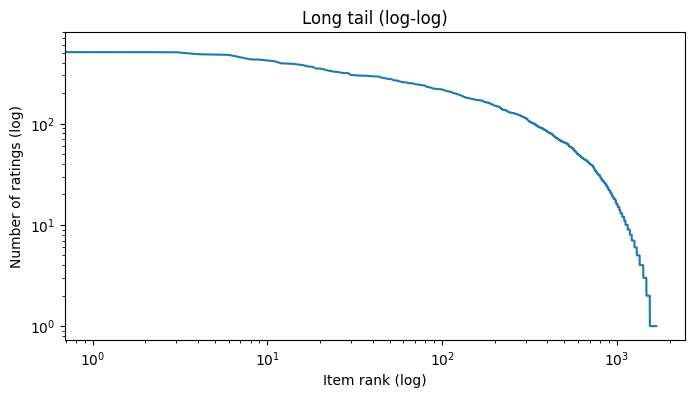

In [21]:
plt.figure(figsize=(8,4))
plt.loglog(items_agg_stats['rank'], items_agg_stats['reviews_cnt'])
plt.xlabel('Item rank (log)')
plt.ylabel('Number of ratings (log)')
plt.title('Long tail (log-log)')
plt.show()

### Cum Sum Previews

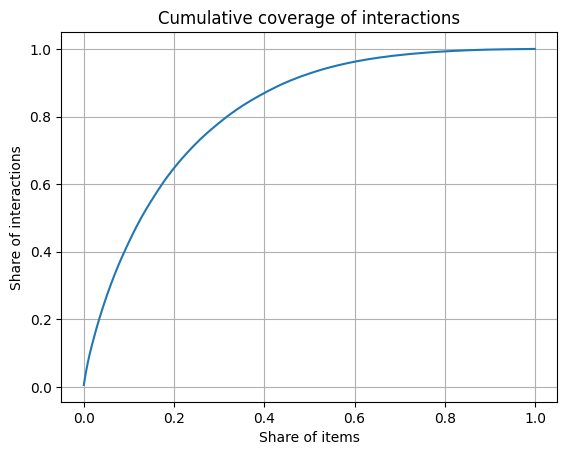

In [22]:
plt.plot(items_agg_stats['rank'] / len(items_agg_stats), items_agg_stats['reviews_share'])
plt.xlabel('Share of items')
plt.ylabel('Share of interactions')
plt.title('Cumulative coverage of interactions')
plt.grid(True)
plt.show()

### Users Long-tail Plots

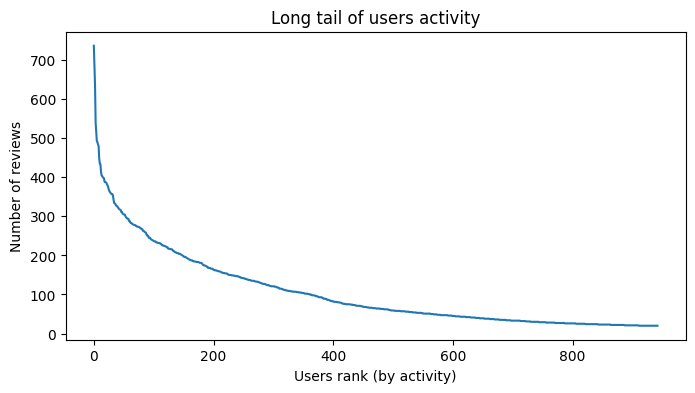

In [38]:
plt.figure(figsize=(8, 4))
plt.plot(users_agg_stats['rank'], users_agg_stats['items_cnt'])
plt.xlabel('Users rank (by activity)')
plt.ylabel('Number of reviews')
plt.title('Long tail of users activity')
plt.show()

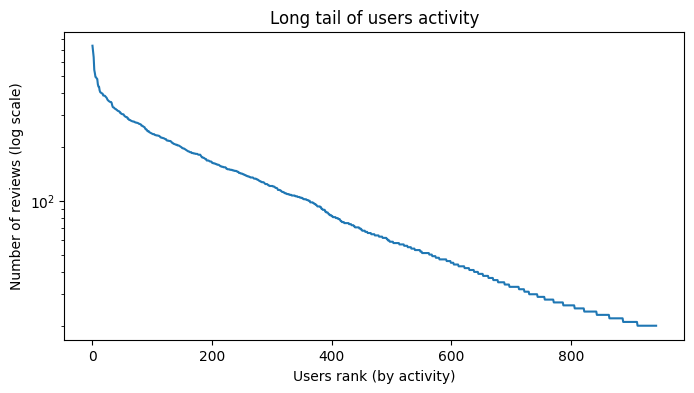

In [40]:
plt.figure(figsize=(8, 4))
plt.plot(users_agg_stats['rank'], users_agg_stats['items_cnt'])
plt.yscale('log')
plt.xlabel('Users rank (by activity)')
plt.ylabel('Number of reviews (log scale)')
plt.title('Long tail of users activity')
plt.show()

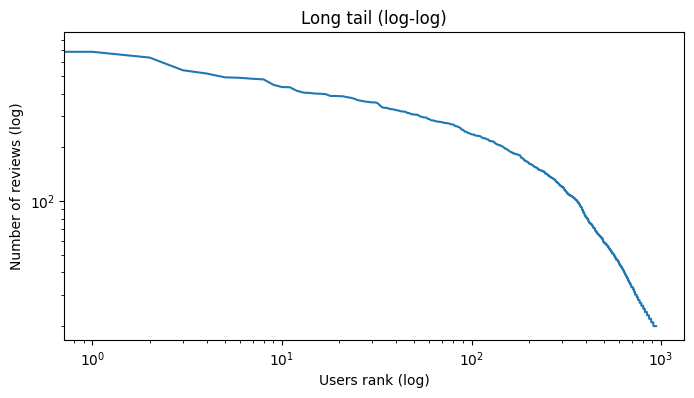

In [41]:
plt.figure(figsize=(8,4))
plt.loglog(users_agg_stats['rank'], users_agg_stats['items_cnt'])
plt.xlabel('Users rank (log)')
plt.ylabel('Number of reviews (log)')
plt.title('Long tail (log-log)')
plt.show()

### Ratings distribution

In [45]:
ratings_agg_stats = items_ratings_stats.groupby('rating').agg(rating_sum=('rating', 'sum'))

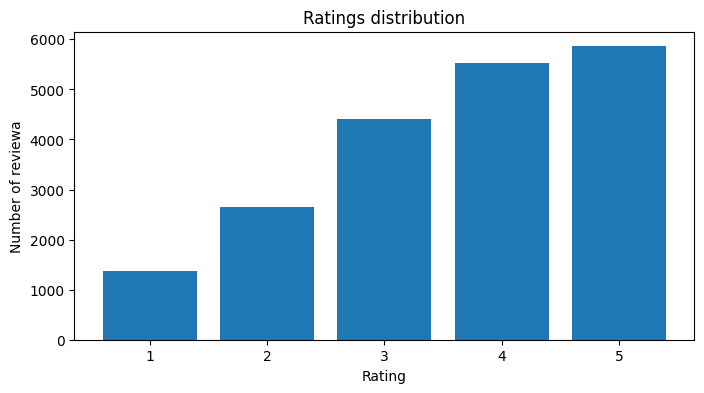

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(ratings_agg_stats.index, ratings_agg_stats['rating_sum'])
plt.xlabel('Rating')
plt.ylabel('Number of reviews')
plt.title('Ratings distribution')
plt.show()

### Avg Rating vs Reviews Count

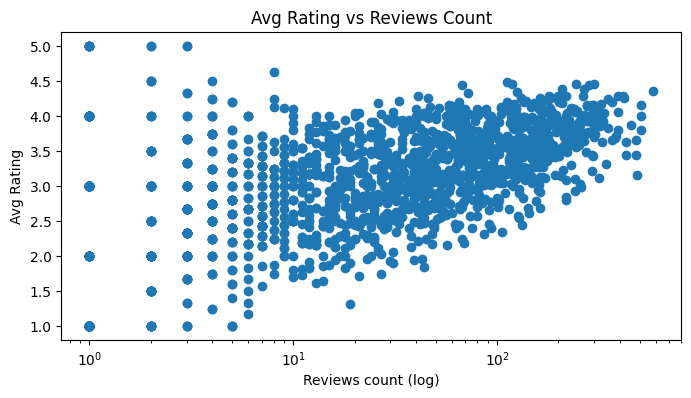

In [56]:
plt.figure(figsize=(8,4))
plt.scatter(items_agg_stats['reviews_cnt'], items_agg_stats['avg_rating'])
plt.xscale('log')
plt.xlabel('Reviews count (log)')
plt.ylabel('Avg Rating')
plt.title('Avg Rating vs Reviews Count')
plt.show()